In [39]:
# 1. Setup and Data Loading

In [40]:
import pandas as pd
import numpy as np
import time
import pickle
import random
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix, f1_score


import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
DATA_PATH = "C:/Users/USER/OneDrive/Desktop/Infinity AI/ApparelWeb/InfinityStyleVerse/backend/app/Neurocoreos/intent_data.csv"
MODEL_OUTPUT_PATH = 'C:/Users/USER/OneDrive/Desktop/Infinity AI/ApparelWeb/InfinityStyleVerse/models/intent_classifier_mvp.pkl'
TEST_SIZE = 0.2
RANDOM_STATE = 42
LATENCY_SAMPLES = 1000 
P95_LATENCY_TARGET_MS = 20

# Load the dataset

df = pd.read_csv(DATA_PATH)
print(f"Data loaded successfully: {len(df)} rows.")


Data loaded successfully: 500 rows.


In [41]:
# Basic exploration

In [42]:
print("Dataset Overview ")
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())

print("\nIntent Class Distribution:")
print(df['intent'].value_counts())

Dataset Overview 
Total samples: 500
Columns: ['text_input', 'intent']

First 5 rows:
                                          text_input                 intent
0       Please generate tell me a joke about python.           unclassified
1     What does an asymmetrical satin gown look like  design_recommendation
2  What is the optimal price for the new denim ja...   pricing_optimization
3  Hi, show me a design sketch for a new t-shirt ...  design_recommendation
4  Please generate i need a mix and match for my ...  outfit_recommendation

Intent Class Distribution:
intent
unclassified             100
design_recommendation    100
pricing_optimization     100
outfit_recommendation    100
fabric_selection         100
Name: count, dtype: int64


In [43]:
#Preprocessing: TF-IDF Vectorization and Split

In [44]:
X_raw = df['text_input'] 
y = df['intent']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("--- Intent Label Encoding Map ---")
for i, label in enumerate(label_encoder.classes_):
    print(f"Intent: {label} -> Encoded: {i}")

indices = np.arange(len(X_raw))
X_train_indices, X_test_indices, y_train_encoded, y_test_encoded = train_test_split(
    indices, y_encoded, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y_encoded
)


y_test = label_encoder.inverse_transform(y_test_encoded) 


print("\nConverting text to numerical features using TF-IDF")
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_features = vectorizer.fit_transform(X_raw)

print(f"Feature matrix shape: {X_features.shape}")

X_train = X_features[X_train_indices]
X_test = X_features[X_test_indices]
X_raw_test = X_raw.iloc[X_test_indices].tolist() 

print(f"\nTraining set features shape: {X_train.shape}")
print(f"Test set features shape: {X_test.shape}")

--- Intent Label Encoding Map ---
Intent: design_recommendation -> Encoded: 0
Intent: fabric_selection -> Encoded: 1
Intent: outfit_recommendation -> Encoded: 2
Intent: pricing_optimization -> Encoded: 3
Intent: unclassified -> Encoded: 4

Converting text to numerical features using TF-IDF
Feature matrix shape: (500, 428)

Training set features shape: (400, 428)
Test set features shape: (100, 428)


In [45]:
#Model Training and Selection

In [46]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, C=1.0),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_estimators=100, learning_rate=0.1),
    "Support Vector Classifier": SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE, probability=True)
}

results = {}
best_f1 = 0
best_model_name = None
best_model = None


for name, model in models.items():
    
    model.fit(X_train, y_train_encoded) 
    y_pred_encoded = model.predict(X_test)
    y_pred = label_encoder.inverse_transform(y_pred_encoded) 

    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    results[name] = {
        'f1_macro': f1_macro,
        'model': model
    }
    
    print(f"  F1 Score (Macro Avg): {f1_macro:.4f}")
    
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_model_name = name
        best_model = model

print(f"Best Model Selected: {best_model_name} (F1: {best_f1:.4f})")

  F1 Score (Macro Avg): 1.0000
  F1 Score (Macro Avg): 0.9800

C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [13:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  F1 Score (Macro Avg): 1.0000
Best Model Selected: Logistic Regression (F1: 1.0000)


In [47]:
#Latency and Confusion Matrix

In [48]:
latencies = []

print(f"\n P95 Latency Check (Target: < {P95_LATENCY_TARGET_MS} ms)")

# Use a random sample of the test set for the check
num_latency_samples = min(LATENCY_SAMPLES, len(X_raw_test))
latency_prompts = random.sample(X_raw_test, num_latency_samples) 

for prompt in latency_prompts:
    start = time.perf_counter()
    _ = final_pipeline.predict([prompt]) 
    end = time.perf_counter()
    latencies.append((end - start) * 1000) 

p95_latency = pd.Series(latencies).quantile(0.95)
latency_passed = p95_latency < P95_LATENCY_TARGET_MS

print(f"Model: {best_model_name}")
print(f"Simulated Inference Latency P95: {p95_latency:.3f} ms")
print(f"Latency P95 < {P95_LATENCY_TARGET_MS} ms Target Met: {'YES' if latency_passed else 'NO'}")


print(f"F1 >= 0.90 Target Met: {'YES' if f1_passed else 'NO'}")


 P95 Latency Check (Target: < 20 ms)
Model: Logistic Regression
Simulated Inference Latency P95: 0.890 ms
Latency P95 < 20 ms Target Met: YES
F1 >= 0.90 Target Met: YES


In [49]:
#Confusion Matrix

In [50]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.



CONFUSION MATRIX (Actual vs. Predicted Module Misroutes
|                               |   Predicted: design_recommendation |   Predicted: fabric_selection |   Predicted: outfit_recommendation |   Predicted: pricing_optimization |   Predicted: unclassified |
|:------------------------------|-----------------------------------:|------------------------------:|-----------------------------------:|----------------------------------:|--------------------------:|
| Actual: design_recommendation |                                 20 |                             0 |                                  0 |                                 0 |                         0 |
| Actual: fabric_selection      |                                  0 |                            20 |                                  0 |                                 0 |                         0 |
| Actual: outfit_recommendation |                                  0 |                             0 |                         

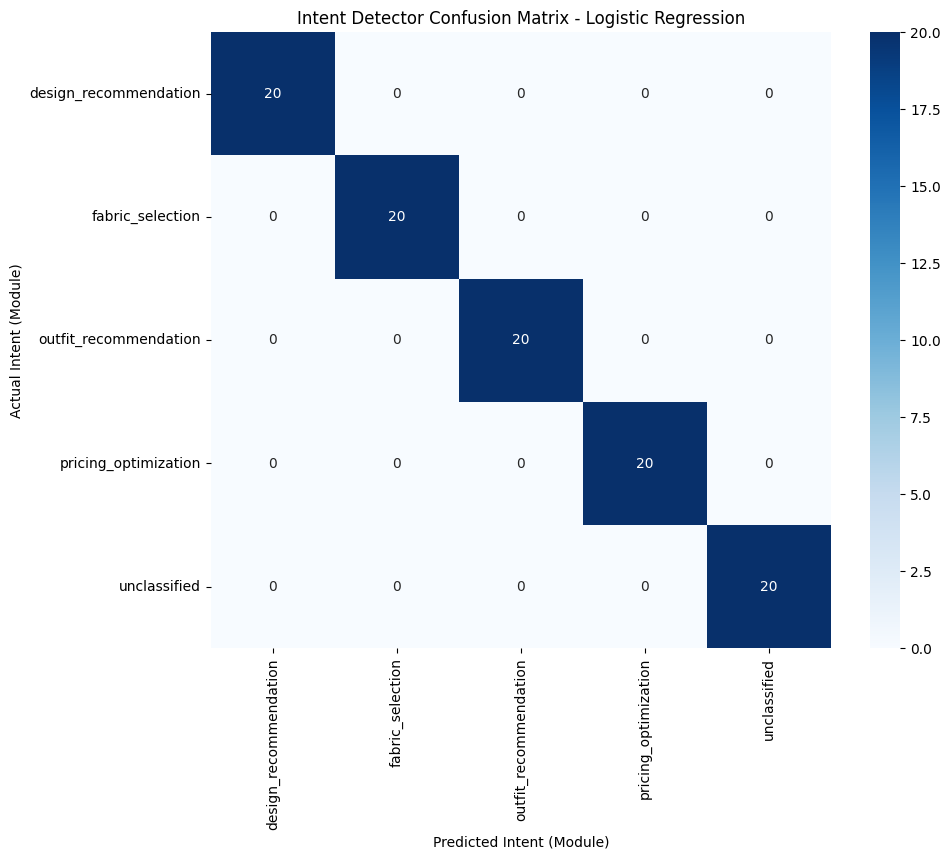


THRESHOLD CALIBRATION ANALYSIS (Threshold >= 0.75)
Accuracy for predictions above threshold: 0.1739
Percentage of samples meeting threshold: 23.00%

Operational Insight: Predictions below this threshold should trigger a safe fallback route to reduce misrouting.


In [51]:
y_pred_final_encoded = final_pipeline.predict(X_raw_test) 


y_pred_final_labels = label_encoder.inverse_transform(y_pred_final_encoded)

print("\nCONFUSION MATRIX (Actual vs. Predicted Module Misroutes")
cm = confusion_matrix(y_test, y_pred_final_labels, labels=label_encoder.classes_)
cm_df = pd.DataFrame(cm, 
                     index=[f'Actual: {c}' for c in label_encoder.classes_], 
                     columns=[f'Predicted: {c}' for c in label_encoder.classes_])
print(cm_df.to_markdown())

# Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f'Intent Detector Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Intent (Module)')
plt.ylabel('Actual Intent (Module)')
plt.show()

THRESHOLD = 0.75 

y_proba = final_pipeline.predict_proba(latency_prompts)
max_confidence = np.max(y_proba, axis=1)


y_pred_confidence_encoded = np.argmax(y_proba, axis=1) 
y_pred_confidence_labels = label_encoder.inverse_transform(y_pred_confidence_encoded)


latency_indices_in_full_data = X_raw.index[X_raw.isin(latency_prompts)]


true_labels_from_full_data = y.loc[latency_indices_in_full_data]


test_indices_set = set(X_test_indices)
y_test_confidence_labels = true_labels_from_full_data[true_labels_from_full_data.index.isin(test_indices_set)].values


high_confidence_indices = (max_confidence >= THRESHOLD)

print(f"\nTHRESHOLD CALIBRATION ANALYSIS (Threshold >= {THRESHOLD})")

if high_confidence_indices.sum() > 0:
    accuracy_above_threshold = (y_pred_confidence_labels[high_confidence_indices] == y_test_confidence_labels[high_confidence_indices]).sum() / high_confidence_indices.sum()

    print(f"Accuracy for predictions above threshold: {accuracy_above_threshold:.4f}")
    print(f"Percentage of samples meeting threshold: {(high_confidence_indices).sum() / len(latency_prompts):.2%}")
    print("\nOperational Insight: Predictions below this threshold should trigger a safe fallback route to reduce misrouting.")
else:
    print("All samples fell below the threshold, indicating the threshold might be too high or data is perfectly separated.")


In [52]:
#Saving the Model

In [53]:
final_artifact = {
    'pipeline': final_pipeline,
    'label_encoder_classes': label_encoder.classes_
    }
with open(MODEL_OUTPUT_PATH, 'wb') as f:
    pickle.dump(final_artifact, f)
print(f"\n SUCCESS: Final artifact ({best_model_name}) saved as {MODEL_OUTPUT_PATH}.")



 SUCCESS: Final artifact (Logistic Regression) saved as C:/Users/USER/OneDrive/Desktop/Infinity AI/ApparelWeb/InfinityStyleVerse/models/intent_classifier_mvp.pkl.
